<a href="https://colab.research.google.com/github/supergarry0715/WEBPAGEFROMAI/blob/main/SPYLV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# =========================
# STEP1 (Colab) - Data Loader + Check + Export to SPY.csv
# =========================
from __future__ import annotations

import pandas as pd
import numpy as np

CONFIG = {
    # data_source: "yfinance" 或 "ibkr_csv"
    "data_source": "yfinance",

    # 若用 ibkr_csv：填你的檔案路徑（Colab 通常是 "/content/xxx.csv"）
    "ibkr_csv_path": "",

    # 若用 yfinance：interval 只允許 yfinance 支援的格式 (例如 "1d", "1h")
    "symbol": "SPY",
    "interval": "1d",

    # 回測期間（含）
    "start": "2010-01-01",
    "end": "2025-12-31",

    # 匯出檔名
    "output_csv": "SPY.csv",
}

# -------------------------
# Helpers
# -------------------------
def _flatten_yfinance_columns(df: pd.DataFrame) -> pd.DataFrame:
    """
    yfinance 有時會回傳 MultiIndex 欄位，例如：
      Price  open/high/low/close/volume
      Ticker spy
    或 columns 形態像 ('open','spy')
    這裡一律壓平為單層：open/high/low/close/volume
    """
    if not isinstance(df.columns, pd.MultiIndex):
        # 已是單層
        df = df.rename(columns=str.lower)
        return df

    wanted = ["open", "high", "low", "close", "volume"]
    lvl0 = df.columns.get_level_values(0).astype(str).str.lower()
    lvl1 = df.columns.get_level_values(1).astype(str).str.lower()

    out = {}
    for w in wanted:
        mask = (lvl0 == w)
        if mask.any():
            # 可能同一欄位在不同 ticker 下出現多次，但你的狀況應該只有 spy
            col = df.columns[mask][0]
            out[w] = df[col]
    df2 = pd.DataFrame(out, index=df.index)

    # 確保有 volume 欄
    if "volume" not in df2.columns:
        df2["volume"] = np.nan

    return df2


def load_from_yfinance(symbol: str, interval: str, start: str, end: str) -> pd.DataFrame:
    import yfinance as yf

    df = yf.download(
        symbol,
        interval=interval,
        start=start,
        end=end,
        auto_adjust=False,
        progress=False,
        actions=False,
    )

    if df is None or df.empty:
        raise ValueError("yfinance 下載結果為空，請檢查 symbol/interval/start/end 是否正確。")

    df.index = pd.to_datetime(df.index)
    df = df.sort_index()

    # 壓平欄位（解決你目前的 Price/Ticker MultiIndex）
    df = _flatten_yfinance_columns(df)

    # 統一欄位小寫
    df = df.rename(columns=str.lower)

    # 僅保留需要欄位
    keep = [c for c in ["open", "high", "low", "close", "volume"] if c in df.columns]
    df = df[keep].copy()

    return df


def load_from_ibkr_csv(path: str) -> pd.DataFrame:
    """
    IBKR 匯出的 CSV 欄名可能不同，這裡做一個保守的自動對應。
    若你的欄名不匹配，錯誤訊息會提示你要怎麼改。
    """
    df = pd.read_csv(path)

    col_map_candidates = {
        "date": ["date", "datetime", "time", "timestamp", "Date", "Datetime", "Time"],
        "open": ["open", "Open"],
        "high": ["high", "High"],
        "low": ["low", "Low"],
        "close": ["close", "Close", "last", "Last"],
        "volume": ["volume", "Volume", "vol", "Vol"],
    }

    def pick_col(possible):
        for c in possible:
            if c in df.columns:
                return c
        return None

    date_col = pick_col(col_map_candidates["date"])
    if date_col is None:
        raise ValueError(f"找不到日期欄位。你的 CSV 欄位有：{list(df.columns)}")

    o = pick_col(col_map_candidates["open"])
    h = pick_col(col_map_candidates["high"])
    l = pick_col(col_map_candidates["low"])
    c = pick_col(col_map_candidates["close"])
    v = pick_col(col_map_candidates["volume"])

    if any(x is None for x in [o, h, l, c]):
        raise ValueError(
            "找不到 OHLC 必要欄位，請在 load_from_ibkr_csv() 內手動對應。\n"
            f"你的 CSV 欄位：{list(df.columns)}\n"
            f"目前偵測到：date={date_col}, open={o}, high={h}, low={l}, close={c}, volume={v}"
        )

    out = df[[date_col, o, h, l, c] + ([v] if v is not None else [])].copy()
    out = out.rename(columns={date_col: "date", o: "open", h: "high", l: "low", c: "close"})
    if v is not None:
        out = out.rename(columns={v: "volume"})
    else:
        out["volume"] = np.nan

    out["date"] = pd.to_datetime(out["date"])
    out = out.set_index("date").sort_index()
    return out


def basic_sanity_checks(df: pd.DataFrame, start: str, end: str) -> pd.DataFrame:
    df = df.loc[pd.to_datetime(start): pd.to_datetime(end)].copy()
    if df.empty:
        raise ValueError("切完 start/end 後資料為空，請檢查日期範圍。")

    required = ["open", "high", "low", "close"]
    for c in required:
        if c not in df.columns:
            raise ValueError(f"缺少必要欄位 {c}，目前欄位：{list(df.columns)}")

    if "volume" not in df.columns:
        df["volume"] = np.nan

    # 缺漏與不合理價格檢查
    na_counts = df[["open", "high", "low", "close", "volume"]].isna().sum()
    bad_price = ((df[["open", "high", "low", "close"]] <= 0).any(axis=1)).sum()

    print("=== Data Check Summary ===")
    print(f"Rows: {len(df):,}")
    print(f"Start: {df.index.min()}  End: {df.index.max()}")

    print("\nNA counts:")
    print(na_counts.to_string())

    print(f"\nBad (<=0) price rows: {bad_price:,}")

    # 頻率/gap 檢查
    deltas = df.index.to_series().diff().dropna()
    if not deltas.empty:
        median_delta = deltas.median()
        print(f"\nMedian time delta: {median_delta}")

        top_gaps = deltas.value_counts().head(10)
        print("\nTop time gaps:")
        print(top_gaps.to_string())

    print("\nHead:")
    print(df.head(5).to_string())

    print("\nTail:")
    print(df.tail(5).to_string())

    return df


def main():
    if CONFIG["data_source"] == "yfinance":
        df = load_from_yfinance(
            CONFIG["symbol"],
            CONFIG["interval"],
            CONFIG["start"],
            CONFIG["end"],
        )
    elif CONFIG["data_source"] == "ibkr_csv":
        if not CONFIG["ibkr_csv_path"]:
            raise ValueError("你選了 ibkr_csv，但沒有填 ibkr_csv_path。")
        df = load_from_ibkr_csv(CONFIG["ibkr_csv_path"])
    else:
        raise ValueError("data_source 只能是 'yfinance' 或 'ibkr_csv'")

    df = basic_sanity_checks(df, CONFIG["start"], CONFIG["end"])

    # ✅ 匯出成 SPY.csv（Step2 會用到）
    out_path = CONFIG["output_csv"]
    df.to_csv(out_path)
    print(f"\n✅ 已成功輸出 CSV：{out_path}")
    print("在 Colab 可用這行確認：!ls")
    print("若要下載到本機：from google.colab import files; files.download('SPY.csv')")


# 直接在 Colab 執行
main()


=== Data Check Summary ===
Rows: 4,023
Start: 2010-01-04 00:00:00  End: 2025-12-30 00:00:00

NA counts:
open      0
high      0
low       0
close     0
volume    0

Bad (<=0) price rows: 0

Median time delta: 1 days 00:00:00

Top time gaps:
Date
1 days    3148
3 days     726
4 days     107
2 days      40
5 days       1

Head:
                  open        high         low       close     volume
Date                                                                 
2010-01-04  112.370003  113.389999  111.510002  113.330002  118944600
2010-01-05  113.260002  113.680000  112.849998  113.629997  111579900
2010-01-06  113.519997  113.989998  113.430000  113.709999  116074400
2010-01-07  113.500000  114.330002  113.180000  114.190002  131091100
2010-01-08  113.889999  114.620003  113.660004  114.570000  126402800

Tail:
                  open        high         low       close    volume
Date                                                                
2025-12-23  683.919983  688.200012  6

In [4]:
!ls


sample_data  SPY.csv


In [5]:
# =========================
# STEP2 (Colab) - Engine Skeleton
# Strict next-bar execution + explicit IBKR commissions + slippage
# =========================
from __future__ import annotations
import pandas as pd
import numpy as np

CONFIG = {
    "csv_path": "SPY.csv",
    "start": "2010-01-01",
    "end": "2025-12-31",

    # ===== A — 成本假設（寫死在程式邏輯中）=====
    # 手續費：每股 $0.005，最低 $1（保守、可調）
    "ibkr_commission_per_share": 0.005,
    "ibkr_min_commission_per_order": 1.0,

    # 滑價：bps（1bp = 0.01%），進出都扣
    "slippage_bps": 1.0,

    # 初始資金
    "initial_capital": 100_000.0,
}

# -------------------------
# Data loader (from Step1 output)
# -------------------------
def load_spy_csv(path: str, start: str, end: str) -> pd.DataFrame:
    df = pd.read_csv(path)

    # Step1 匯出的 CSV index 會叫 date 或 Date；我們做容錯
    if "Date" in df.columns:
        df["Date"] = pd.to_datetime(df["Date"])
        df = df.set_index("Date")
    elif "date" in df.columns:
        df["date"] = pd.to_datetime(df["date"])
        df = df.set_index("date")
    else:
        # 如果你的 Step1 是直接 df.to_csv，index 可能會在第一欄 unnamed
        first = df.columns[0]
        df[first] = pd.to_datetime(df[first])
        df = df.set_index(first)

    df = df.sort_index()
    df.columns = [c.lower() for c in df.columns]
    df = df.loc[pd.to_datetime(start): pd.to_datetime(end)].copy()

    need = ["open", "high", "low", "close"]
    for c in need:
        if c not in df.columns:
            raise ValueError(f"缺少必要欄位 {c}，目前欄位：{list(df.columns)}")
    if "volume" not in df.columns:
        df["volume"] = np.nan

    return df


# -------------------------
# A — Cost model (explicit)
# -------------------------
def commission_ibkr(num_shares: float, cfg: dict) -> float:
    fee = abs(num_shares) * cfg["ibkr_commission_per_share"]
    return max(fee, cfg["ibkr_min_commission_per_order"])


def slippage_cost(trade_price: float, num_shares: float, cfg: dict) -> float:
    bps = cfg["slippage_bps"] / 10_000.0
    notional = abs(num_shares) * trade_price
    return notional * bps


# -------------------------
# Example strategy signal (validation only)
# L — No lookahead: rolling uses past only
# E — Execution next bar happens in backtest via shift(1)
# -------------------------
def example_signal_sma_cross(df: pd.DataFrame, fast: int = 20, slow: int = 60) -> pd.Series:
    fast_sma = df["close"].rolling(fast, min_periods=fast).mean()
    slow_sma = df["close"].rolling(slow, min_periods=slow).mean()
    sig = (fast_sma > slow_sma).astype(int)  # 1=long, 0=flat
    return sig


# -------------------------
# Backtest engine (long-only, full in/out)
# E — strictly next-bar execution using open of next bar
# -------------------------
def backtest_long_only_nextbar(df: pd.DataFrame, signal: pd.Series, cfg: dict) -> pd.DataFrame:
    df = df.copy()
    signal = signal.reindex(df.index).fillna(0).astype(int)

    # E: next bar execution (signal at t -> position at t+1)
    position = signal.shift(1).fillna(0).astype(int)

    # trades: +1 buy, -1 sell
    trade = position.diff().fillna(position)

    capital = float(cfg["initial_capital"])
    shares = 0.0
    equity_curve = []

    # Record costs for transparency
    comm_list = []
    slip_list = []

    for t, row in df.iterrows():
        open_px = float(row["open"])
        close_px = float(row["close"])
        tr = float(trade.loc[t])

        comm = 0.0
        slip = 0.0

        if tr == 1.0:  # buy at open
            # naive target: invest all capital
            # cost first (conservative): subtract costs from capital then buy
            # estimate shares using pre-cost, then compute cost, then recompute affordable shares
            est_shares = capital / open_px
            comm = commission_ibkr(est_shares, cfg)
            slip = slippage_cost(open_px, est_shares, cfg)
            total_cost = comm + slip

            capital_after_cost = capital - total_cost
            if capital_after_cost > 0:
                shares = capital_after_cost / open_px
                capital = 0.0
            else:
                # too costly / invalid -> skip trade (conservative)
                comm = 0.0
                slip = 0.0

        elif tr == -1.0:  # sell at open
            comm = commission_ibkr(shares, cfg)
            slip = slippage_cost(open_px, shares, cfg)
            total_cost = comm + slip

            proceeds = shares * open_px
            capital = proceeds - total_cost
            shares = 0.0

        # mark-to-market at close
        equity = capital + shares * close_px
        equity_curve.append(equity)
        comm_list.append(comm)
        slip_list.append(slip)

    out = df.copy()
    out["signal_raw"] = signal
    out["position_exec"] = position
    out["trade"] = trade
    out["commission"] = comm_list
    out["slippage"] = slip_list
    out["equity"] = equity_curve
    out["ret"] = out["equity"].pct_change().fillna(0.0)

    return out


# -------------------------
# Simple metrics (validation only)
# -------------------------
def quick_metrics(equity: pd.Series) -> dict:
    rets = equity.pct_change().dropna()
    if rets.empty:
        return {"Sharpe": np.nan, "MaxDD": np.nan, "CAGR": np.nan}

    ann = 252.0
    sharpe = (rets.mean() / (rets.std(ddof=0) + 1e-12)) * np.sqrt(ann)

    peak = equity.cummax()
    dd = equity / peak - 1.0
    maxdd = dd.min()

    years = (equity.index[-1] - equity.index[0]).days / 365.25
    cagr = (equity.iloc[-1] / equity.iloc[0]) ** (1.0 / years) - 1.0 if years > 0 else np.nan

    return {"Sharpe": float(sharpe), "MaxDD": float(maxdd), "CAGR": float(cagr)}


# -------------------------
# Run Step2
# -------------------------
df = load_spy_csv(CONFIG["csv_path"], CONFIG["start"], CONFIG["end"])
print("=== STEP2: Engine Skeleton Check ===")
print(f"Rows: {len(df):,} | Start: {df.index.min()} | End: {df.index.max()}")
print("Columns:", list(df.columns))

sig = example_signal_sma_cross(df, fast=20, slow=60)
res = backtest_long_only_nextbar(df, sig, CONFIG)

m = quick_metrics(res["equity"])
print("\nQuick metrics (EXAMPLE strategy, engine validation only):")
print(m)

print("\nFirst 5 trade rows (to verify next-bar execution):")
print(res.loc[res["trade"] != 0, ["signal_raw", "position_exec", "trade", "commission", "slippage"]].head(5).to_string())

print("\nFinal equity:", float(res["equity"].iloc[-1]))
print("Total commission:", float(res["commission"].sum()))
print("Total slippage:", float(res["slippage"].sum()))


=== STEP2: Engine Skeleton Check ===
Rows: 4,023 | Start: 2010-01-04 00:00:00 | End: 2025-12-30 00:00:00
Columns: ['open', 'high', 'low', 'close', 'volume']

Quick metrics (EXAMPLE strategy, engine validation only):
{'Sharpe': 0.5903505916564058, 'MaxDD': -0.2627339419135831, 'CAGR': 0.06406694605763952}

First 5 trade rows (to verify next-bar execution):
            signal_raw  position_exec  trade  commission   slippage
Date                                                               
2010-03-31           1              1    1.0    4.275331  10.000000
2010-05-21           0              0   -1.0    4.274721   9.054715
2010-08-05           1              1    1.0    4.032687   9.053382
2010-09-02           0              0   -1.0    4.032104   8.767407
2010-09-16           1              1    1.0    3.888107   8.766127

Final equity: 269857.22886279615
Total commission: 222.46141721679604
Total slippage: 1140.965503695671


=== STEP3 v2 (vol_floor) ===
Total windows: 12
Fixed params: {'fast': 10, 'slow': 40, 'thr': 0.005, 'vol_window': 40, 'target_vol': 0.1, 'max_lev': 1.5}
vol_floor candidates: [0.1, 0.12, 0.14, 0.16] | vol_floor_window: 20

=== Candidate Summary (sorted by robust score) ===


,vol_floor,mean_test_sh,std_test_sh,mean_test_cagr,worst_dd,mean_deg_vt,score,verdict,total_test_tradedays
0,0.10,0.887443,0.963157,0.036913,-0.058496,0.579600,-0.154547,⚠️ 脆弱,795
1,0.12,0.704461,0.919079,0.018939,-0.058507,0.543711,-0.289640,⚠️ 脆弱,494



=== BEST vol_floor ===
vol_floor: 0.1
Detail: {'mean_test_sh': 0.8874428117949168, 'std_test_sh': 0.9631569972440243, 'mean_test_cagr': 0.036912573872277726, 'worst_dd': -0.05849639980987209, 'mean_deg_vt': 0.5796002488392141, 'score': -0.15454729201629525}
Final Verdict: ⚠️ 脆弱

=== STEP3 OUTPUT (fixed params + best vol_floor) ===


,Window,Train_Sharpe,Train_MaxDD,Train_CAGR,Train_TradeDays,Val_Sharpe,Val_MaxDD,Val_CAGR,Val_TradeDays,Test_Sharpe,Test_MaxDD,Test_CAGR,Test_TradeDays
0,1,-0.724076,-0.118308,-0.046772,194,0.449052,-0.041817,0.024260,91,1.379219,-0.019254,0.061371,74
1,2,-0.616377,-0.126488,-0.036248,185,1.379219,-0.019254,0.061371,74,0.690734,-0.019662,0.022168,35
2,3,1.335671,-0.041817,0.071334,190,0.690422,-0.019662,0.022158,35,-0.013944,-0.027536,-0.001418,58
3,4,1.152736,-0.022297,0.046827,124,-0.014776,-0.027542,-0.001452,58,0.507452,-0.017150,0.011376,58
4,5,0.360431,-0.027540,0.013095,106,0.506127,-0.017153,0.011345,58,NaN,0.000000,0.000000,0
5,6,0.316825,-0.027542,0.010159,120,NaN,0.000000,0.000000,0,0.106679,-0.008827,0.001255,16
6,7,0.357795,-0.017153,0.005649,58,0.106129,-0.008828,0.001248,16,1.781136,-0.019460,0.056165,53
7,8,-0.615893,-0.058568,-0.021930,22,1.780092,-0.019463,0.056129,53,0.538262,-0.056117,0.031013,141
8,9,1.583853,-0.019462,0.040353,92,0.535197,-0.056146,0.030823,141,1.258968,-0.031386,0.076367,95
9,10,-0.003021,-0.111604,-0.002301,216,1.256812,-0.031394,0.076227,95,-0.922035,-0.058496,-0.046850,80


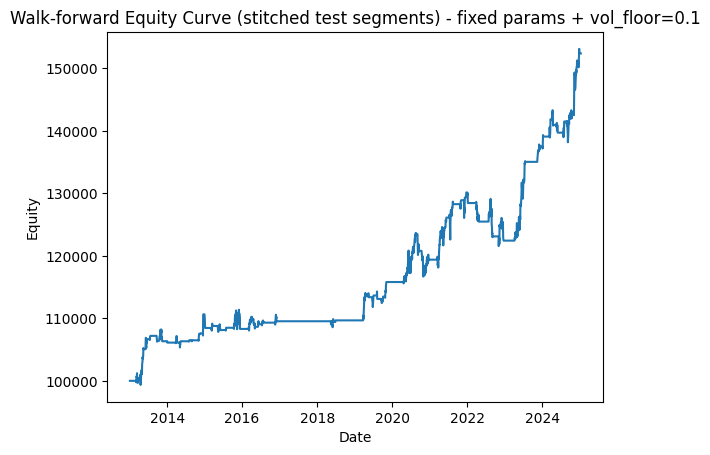

In [12]:
from __future__ import annotations
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# =========================
# STEP3 v2 - FIXED robust params + vol_floor filter (only 1 new parameter)
# REAL: walk-forward 50/25/25, strict next-bar open execution, explicit costs, no lookahead
# =========================

CONFIG = {
    "csv_path": "SPY.csv",
    "start": "2010-01-01",
    "end": "2025-12-31",

    # A — costs
    "ibkr_commission_per_share": 0.005,
    "ibkr_min_commission_per_order": 1.0,
    "slippage_bps": 1.0,

    "initial_capital": 100_000.0,

    # R — walk-forward windows
    "min_total_window_bars": 252 * 4,
    "min_trades_per_segment": 5,

    # Fixed deployable setting (from your BEST ROBUST PARAMS)
    "fast": 10,
    "slow": 40,
    "thr": 0.005,
    "vol_window": 40,
    "target_vol": 0.10,
    "max_lev": 1.5,

    # NEW: vol_floor scan (you said OK)
    "vol_floor_list": [0.10, 0.12, 0.14, 0.16],
    "vol_floor_window": 20,  # fixed, conservative

    # Robust scoring across windows (OOS-first)
    "w_mean_test_sh": 1.00,
    "w_std_test_sh": 0.70,
    "w_deg_vt": 0.60,
    "w_worst_dd": 0.50,
    "w_mean_test_cagr": 0.25,
}

def load_spy_csv(path: str, start: str, end: str) -> pd.DataFrame:
    df = pd.read_csv(path)
    if "Date" in df.columns:
        df["Date"] = pd.to_datetime(df["Date"]); df = df.set_index("Date")
    elif "date" in df.columns:
        df["date"] = pd.to_datetime(df["date"]); df = df.set_index("date")
    else:
        first = df.columns[0]
        df[first] = pd.to_datetime(df[first]); df = df.set_index(first)
    df = df.sort_index()
    df.columns = [c.lower() for c in df.columns]
    df = df.loc[pd.to_datetime(start): pd.to_datetime(end)].copy()
    for c in ["open", "high", "low", "close"]:
        if c not in df.columns:
            raise ValueError(f"缺少必要欄位 {c}，目前欄位：{list(df.columns)}")
    if "volume" not in df.columns:
        df["volume"] = np.nan
    return df

def commission_ibkr(num_shares: float, cfg: dict) -> float:
    fee = abs(num_shares) * cfg["ibkr_commission_per_share"]
    return max(fee, cfg["ibkr_min_commission_per_order"])

def slippage_cost(trade_price: float, num_shares: float, cfg: dict) -> float:
    bps = cfg["slippage_bps"] / 10_000.0
    return abs(num_shares) * trade_price * bps

def walkforward_windows(df: pd.DataFrame, min_total_bars: int):
    n = len(df)
    W = min_total_bars
    train_len = int(W * 0.50)
    val_len = int(W * 0.25)
    test_len = W - train_len - val_len
    start = 0
    while start + W <= n:
        end = start + W
        idx = df.index[start:end]
        yield idx[:train_len], idx[train_len:train_len+val_len], idx[train_len+val_len:]
        start += test_len

def precompute_sma(df_seg: pd.DataFrame, lengths: list[int]) -> dict[int, pd.Series]:
    out = {}
    for L in sorted(set(lengths)):
        out[L] = df_seg["close"].rolling(L, min_periods=L).mean()
    return out

def vol_target_leverage(df_seg: pd.DataFrame, vol_window: int, target_ann_vol: float, max_leverage: float) -> pd.Series:
    r = df_seg["close"].pct_change()
    vol_daily = r.rolling(vol_window, min_periods=vol_window).std(ddof=0)
    vol_ann = vol_daily * np.sqrt(252.0)
    lev = target_ann_vol / (vol_ann + 1e-12)
    return lev.clip(0.0, max_leverage).fillna(0.0)

def realized_vol_ann(df_seg: pd.DataFrame, window: int) -> pd.Series:
    r = df_seg["close"].pct_change()
    vol_daily = r.rolling(window, min_periods=window).std(ddof=0)
    return (vol_daily * np.sqrt(252.0)).fillna(0.0)

def make_signal(df_seg: pd.DataFrame, sma_map: dict[int, pd.Series], fast: int, slow: int, thr: float,
                vol_floor_series: pd.Series, vol_floor: float) -> pd.Series:
    fast_sma = sma_map[fast]
    slow_sma = sma_map[slow]
    base = fast_sma > slow_sma
    strength = ((fast_sma - slow_sma) / (slow_sma + 1e-12)) >= thr

    # NEW filter: only trade when realized vol >= vol_floor
    vol_ok = (vol_floor_series >= vol_floor)

    return (base & strength & vol_ok).astype(int)

def backtest_nextbar(df_seg: pd.DataFrame, signal_raw: pd.Series, lev_raw: pd.Series, cfg: dict) -> pd.DataFrame:
    df_seg = df_seg.copy()
    signal_raw = signal_raw.reindex(df_seg.index).fillna(0).astype(int)
    lev_raw = lev_raw.reindex(df_seg.index).fillna(0.0).astype(float)

    # E: strict next-bar execution
    pos_exec = signal_raw.shift(1).fillna(0).astype(int)
    lev_exec = lev_raw.shift(1).fillna(0.0)
    expo = (pos_exec.astype(float) * lev_exec).clip(0.0)

    capital = float(cfg["initial_capital"])
    shares = 0.0
    equity_curve = []
    trade_dir = []

    for t, row in df_seg.iterrows():
        open_px = float(row["open"])
        close_px = float(row["close"])
        target_expo = float(expo.loc[t])

        equity_open = capital + shares * open_px
        target_notional = equity_open * target_expo
        target_shares = target_notional / open_px if open_px > 0 else 0.0
        delta = target_shares - shares

        if abs(delta) > 1e-12:
            comm = commission_ibkr(delta, cfg)
            slip = slippage_cost(open_px, delta, cfg)
            cash_flow = -delta * open_px
            capital = capital + cash_flow - (comm + slip)
            shares = target_shares
            trade_dir.append(float(np.sign(delta)))
        else:
            trade_dir.append(0.0)

        equity_curve.append(capital + shares * close_px)

    out = df_seg.copy()
    out["equity"] = equity_curve
    out["ret"] = out["equity"].pct_change().fillna(0.0)
    out["trade_dir"] = trade_dir
    return out

def segment_metrics(res: pd.DataFrame) -> dict:
    eq = res["equity"]
    rets = res["ret"].dropna()
    sharpe = np.nan
    if len(rets) > 5 and rets.std(ddof=0) > 0:
        sharpe = (rets.mean() / (rets.std(ddof=0) + 1e-12)) * np.sqrt(252.0)
    peak = eq.cummax()
    dd = eq / peak - 1.0
    maxdd = float(dd.min())
    years = (eq.index[-1] - eq.index[0]).days / 365.25
    cagr = float((eq.iloc[-1] / eq.iloc[0]) ** (1.0 / years) - 1.0) if years > 0 else np.nan
    trades = int((res["trade_dir"] != 0).sum())
    return {"Sharpe": float(sharpe) if sharpe == sharpe else np.nan, "MaxDD": maxdd, "CAGR": cagr, "TradeDays": trades}

def robust_score_across_windows(wf_df: pd.DataFrame, cfg: dict) -> tuple[float, dict]:
    mean_test_sh = wf_df["Test_Sharpe"].mean()
    std_test_sh  = wf_df["Test_Sharpe"].std(ddof=0)
    mean_test_cagr = wf_df["Test_CAGR"].mean()
    worst_dd = wf_df["Test_MaxDD"].min()
    mean_deg_vt = (wf_df["Val_Sharpe"] - wf_df["Test_Sharpe"]).clip(lower=0).mean()

    score = (
        cfg["w_mean_test_sh"] * mean_test_sh
        - cfg["w_std_test_sh"] * std_test_sh
        - cfg["w_deg_vt"] * mean_deg_vt
        - cfg["w_worst_dd"] * abs(worst_dd)
        + cfg["w_mean_test_cagr"] * mean_test_cagr
    )

    detail = {
        "mean_test_sh": float(mean_test_sh),
        "std_test_sh": float(std_test_sh),
        "mean_test_cagr": float(mean_test_cagr),
        "worst_dd": float(worst_dd),
        "mean_deg_vt": float(mean_deg_vt),
        "score": float(score),
    }
    return float(score), detail

def verdict_from_detail(d: dict) -> str:
    if (d["mean_test_sh"] >= 0.5) and (d["std_test_sh"] <= 0.7) and (d["worst_dd"] >= -0.45):
        return "✅ 穩健"
    elif (d["mean_test_sh"] >= 0.2) and (d["worst_dd"] >= -0.60):
        return "⚠️ 脆弱"
    else:
        return "❌ 不可部署"

# =========================
# RUN
# =========================
df = load_spy_csv(CONFIG["csv_path"], CONFIG["start"], CONFIG["end"])
windows = list(walkforward_windows(df, CONFIG["min_total_window_bars"]))
print(f"=== STEP3 v2 (vol_floor) ===\nTotal windows: {len(windows)}")

fixed = {k: CONFIG[k] for k in ["fast","slow","thr","vol_window","target_vol","max_lev"]}
print("Fixed params:", fixed)
print("vol_floor candidates:", CONFIG["vol_floor_list"], "| vol_floor_window:", CONFIG["vol_floor_window"])

# Prepare caches per window (speed)
sma_lengths = [CONFIG["fast"], CONFIG["slow"]]
cache = []
for (tr_idx, v_idx, t_idx) in windows:
    df_tr = df.loc[tr_idx]; df_v = df.loc[v_idx]; df_t = df.loc[t_idx]
    cache.append({
        "df_tr": df_tr, "df_v": df_v, "df_t": df_t,
        "sma_tr": precompute_sma(df_tr, sma_lengths),
        "sma_v":  precompute_sma(df_v,  sma_lengths),
        "sma_t":  precompute_sma(df_t,  sma_lengths),
        "rv_tr": realized_vol_ann(df_tr, CONFIG["vol_floor_window"]),
        "rv_v":  realized_vol_ann(df_v,  CONFIG["vol_floor_window"]),
        "rv_t":  realized_vol_ann(df_t,  CONFIG["vol_floor_window"]),
    })

all_summaries = []
best_vf = None
best_score = -1e9
best_detail = None
best_wf_df = None
best_eq = None

for vol_floor in CONFIG["vol_floor_list"]:
    rows = []
    eq_parts = []
    current_cap = CONFIG["initial_capital"]

    for wno, item in enumerate(cache, start=1):
        df_tr, df_v, df_t = item["df_tr"], item["df_v"], item["df_t"]

        # TRAIN (report)
        sig_tr = make_signal(df_tr, item["sma_tr"], CONFIG["fast"], CONFIG["slow"], CONFIG["thr"], item["rv_tr"], vol_floor)
        lev_tr = vol_target_leverage(df_tr, CONFIG["vol_window"], CONFIG["target_vol"], CONFIG["max_lev"])
        res_tr = backtest_nextbar(df_tr, sig_tr, lev_tr, CONFIG)
        m_tr = segment_metrics(res_tr)

        # VAL
        sig_v = make_signal(df_v, item["sma_v"], CONFIG["fast"], CONFIG["slow"], CONFIG["thr"], item["rv_v"], vol_floor)
        lev_v = vol_target_leverage(df_v, CONFIG["vol_window"], CONFIG["target_vol"], CONFIG["max_lev"])
        res_v = backtest_nextbar(df_v, sig_v, lev_v, CONFIG)
        m_v = segment_metrics(res_v)

        # TEST stitched
        cfg_test = dict(CONFIG); cfg_test["initial_capital"] = current_cap
        sig_t = make_signal(df_t, item["sma_t"], CONFIG["fast"], CONFIG["slow"], CONFIG["thr"], item["rv_t"], vol_floor)
        lev_t = vol_target_leverage(df_t, CONFIG["vol_window"], CONFIG["target_vol"], CONFIG["max_lev"])
        res_t = backtest_nextbar(df_t, sig_t, lev_t, cfg_test)
        m_t = segment_metrics(res_t)

        current_cap = float(res_t["equity"].iloc[-1])
        eq_parts.append(res_t[["equity"]].copy())

        rows.append({
            "Window": wno,
            "Train_Sharpe": m_tr["Sharpe"], "Train_MaxDD": m_tr["MaxDD"], "Train_CAGR": m_tr["CAGR"], "Train_TradeDays": m_tr["TradeDays"],
            "Val_Sharpe": m_v["Sharpe"], "Val_MaxDD": m_v["MaxDD"], "Val_CAGR": m_v["CAGR"], "Val_TradeDays": m_v["TradeDays"],
            "Test_Sharpe": m_t["Sharpe"], "Test_MaxDD": m_t["MaxDD"], "Test_CAGR": m_t["CAGR"], "Test_TradeDays": m_t["TradeDays"],
        })

    wf_df = pd.DataFrame(rows)

    # Filter: require enough trades overall to avoid "too defensive"
    if wf_df["Test_TradeDays"].sum() < 400:
        # Too few trades across all windows (rule-of-thumb), likely over-filtering
        continue

    score, detail = robust_score_across_windows(wf_df, CONFIG)
    verdict = verdict_from_detail(detail)

    all_summaries.append({
        "vol_floor": vol_floor,
        **detail,
        "verdict": verdict,
        "total_test_tradedays": int(wf_df["Test_TradeDays"].sum())
    })

    if score > best_score:
        best_score = score
        best_vf = vol_floor
        best_detail = detail
        best_wf_df = wf_df
        best_eq = pd.concat(eq_parts).sort_index()

summary_df = pd.DataFrame(all_summaries).sort_values(by="score", ascending=False)

print("\n=== Candidate Summary (sorted by robust score) ===")
display(summary_df)

if best_vf is None:
    print("No vol_floor candidate produced usable results (possibly too strict).")
else:
    print("\n=== BEST vol_floor ===")
    print("vol_floor:", best_vf)
    print("Detail:", best_detail)
    print("Final Verdict:", verdict_from_detail(best_detail))

    print("\n=== STEP3 OUTPUT (fixed params + best vol_floor) ===")
    display(best_wf_df)

    plt.figure()
    plt.plot(best_eq.index, best_eq["equity"])
    plt.title(f"Walk-forward Equity Curve (stitched test segments) - fixed params + vol_floor={best_vf}")
    plt.xlabel("Date")
    plt.ylabel("Equity")
    plt.show()
